In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random
from sklearn import datasets, mixture 
from sklearn.cluster import DBSCAN
import imageio
import matplotlib.gridspec as gridspec
    
  
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

# Project Objectives

Heart rate data is used in several ways. One can select a target heart rate to stay under, so that the pace can be maintained, or one can target the highest rates for improving fitness. For example, one may want to stay under 140 for a long distance race, or may want to stay well above 140 in a short but high intensity session to improve fitness. 

To help with this last activity, this project will analyze heart rate data to determine if machine learning and clustering algorithms can indetify a high intensity zone for a given individual. The process will be to load and filter the data, select a sample, optimize hyper-paramters and select a model based on performance metrics.  

# Loading and Pre-Processing

The dataset is from one 63 year old white male exported from the Apple Health app. No features were available. For ill be analyzed.The .csv file was over 100MB, the limit for github. Consequently the data file was converted into a pickle file and is loaded below.

In [3]:
# The dataset for this project consist of heart rate data collected over 4 years 
# during various physical activities: biking, walking, skiing. 

#csv_file = 'data/HeartRateDataRaw.csv'
#df_raw = pd.read_csv(csv_file, header=0)
#df_raw.to_pickle('./data/HeartRateDataRaw.pickle')

df_raw=pd.read_pickle('./data/HeartRateDataRaw.pickle')
df_raw.head()

,/@locale,/ExportDate/@value,/Me/@HKCharacteristicTypeIdentifierBiologicalSex,/Me/@HKCharacteristicTypeIdentifierBloodType,/Me/@HKCharacteristicTypeIdentifierDateOfBirth,/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType,/Record/@creationDate,/Record/@device,/Record/@endDate,/Record/@sourceName,/Record/@sourceVersion,/Record/@startDate,/Record/@type,/Record/@unit,/Record/@value,/Record/MetadataEntry/@key,/Record/MetadataEntry/@value,/Record/MetadataEntry/@value/#agg
0,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,12/21/14 19:13,NaN,12/21/14 19:13,Health,NaN,12/21/14 19:13,HKQuantityTypeIdentifierBodyMassIndex,count,26.29000,HKWasUserEntered,1.0,1.0
1,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,10/2/14 17:40,NaN,10/2/14 17:40,Health,NaN,10/2/14 17:40,HKQuantityTypeIdentifierHeight,ft,5.66667,HKWasUserEntered,1.0,1.0
2,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,11/24/14 15:22,NaN,11/24/14 15:22,Health,NaN,11/24/14 15:22,HKQuantityTypeIdentifierHeight,ft,4.83333,HKWasUserEntered,1.0,1.0
3,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,8/8/15 19:20,NaN,8/8/15 19:20,Toms iPhone6,NaN,8/8/15 19:20,HKQuantityTypeIdentifierHeight,ft,5.66667,NaN,NaN,NaN
4,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,8/8/15 19:29,NaN,8/8/15 19:29,Thomas's Apple Watch,NaN,8/8/15 19:29,HKQuantityTypeIdentifierHeight,ft,5.66667,NaN,NaN,NaN


In [4]:
# Displaying the list of column names in the heart rate export: 
for col in df_raw.columns:
    print (col)

/@locale
/ExportDate/@value
/Me/@HKCharacteristicTypeIdentifierBiologicalSex
/Me/@HKCharacteristicTypeIdentifierBloodType
/Me/@HKCharacteristicTypeIdentifierDateOfBirth
/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType
/Record/@creationDate
/Record/@device
/Record/@endDate
/Record/@sourceName
/Record/@sourceVersion
/Record/@startDate
/Record/@type
/Record/@unit
/Record/@value
/Record/MetadataEntry/@key
/Record/MetadataEntry/@value
/Record/MetadataEntry/@value/#agg


## Selecting Fields of Interest
The only feature of interest is '/Record/@value'. It contains the beats per minute data. The other fields could be of interest, but they were either not populated, had only a single value (sex = male) or not expected to be relevant. The code below selects only the '/Record/@value' parameter and renames it to 'BPM'. In an ideal dataset scenario, multiple people of both sexes, a wide range of ages and different devices would also be included. For this exploratory analysis, this limited dataset should be sufficient. 

In [5]:
# Creating dataframe with only beats per minute (BPM) data then renaming only the BPM values: 
df_raw = df_raw.filter(items=['/Record/@value'])
df_raw = df_raw.rename(columns={'/Record/@value':"BPM"})
df_raw.head(3)

,BPM
0,26.29000
1,5.66667
2,4.83333



# Setting Parameters and Limits
### Hardware Limits, Sample Size, Maximum HR 

The heart rate data was obtained from an Apple Watch and exported from Healthkit. Do to the sensitivity and availability of health data, the dataset is collected from only one white 63 year old male. The watch sensor's valid hardware limits are from 30 bpm to 210 bpm. Values outside of this range were filtered. Do to the large database with over 349,000 data points, a random sample of 10,000 from this population was generated. This did not significantly affect the distribution or results but did improve execution time. 

Maximum heart can be calculated from age. The formula is 220-age. There is no comparable algorithm for minimum heart rate. In general, a lower resting heart rate is indicative of better conditioning. 

In [6]:
# Configuration Parameters including hardware sensor limits, maximum heart rate and sample size are defined. 
# To calculate maximum heart rate, the formula 220 - age is used. 
age = 63 
max_hr = 220-age
sample_size = 10000
hardware_upper_limit = 210
hardware_lower_limit = 30

### Heart Rate Zone Limits

Various heart rate zones have been defined. They range from resting to high intensity zones. There is no standard. Polar heart rate monitors have been in use by atheletes for decades and have 5 zones. The CDC and Mayo clinic define two exercise zones, moderate and intense. While the zones for each of these sources have different limits, all use the same calculation for maximum hear rate, namely 220-age. Clustering algorithms will also be applied to the data with each cluster defining a zone. 

The limits for the CDC, Polar and Mayo Clinic zones are defined in the dictionaries below: 

In [7]:
#Dictionaries are defined for Mayo Clinic, CDC and Polar (tm) heart rate zones: 
mayo_limits = {'moderate_low':0.50*max_hr,'moderate_hi':0.7*max_hr,'intensity_low':0.70*max_hr,'intensity_hi':0.85*max_hr}
cdc_limits = {'moderate_low':0.64*max_hr,'moderate_hi':0.76*max_hr,'intensity_low':0.76*max_hr,'intensity_hi':0.93*max_hr}
polar_limits = {'zone1':0.6*max_hr,'zone2':0.7*max_hr,'zone3':0.80*max_hr,'zone4':0.9*max_hr,'zone5':1*max_hr}

# Explore the Data
It is now time to explore the data. A display of the raw dataframe, summary
statistics and graphical analysis will all be used to understand the dataset. 
### Descriptive Statistics
The summary below shows that there were 349,781 heat beat measurements. The minimum was 5 and the maximum is 215. These values are outside of the sensor's valid range, which is 30 to 210. Consequently, they will be filtered out. 
The mean at 78 bpm is significantly above the median at 69 bpm, suggesting there the distribution has a high end tail. The standard distribution of 24 is also high further suggesting a wide range of values. 

In [8]:
display (df_raw.head())
# The summary statistics for heart rate data on the full dataset: 
display (round(df_raw.BPM.describe()))

,BPM
0,26.29000
1,5.66667
2,4.83333
3,5.66667
4,5.66667


count    349781.0
mean         78.0
std          24.0
min           5.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64

### Filter Outliers
The hardware limits noted above will be applied to the dataset: 

In [9]:
# Apply hardware limits:
df_limit = df_raw[(df_raw['BPM'] <= hardware_upper_limit) & (df_raw['BPM'] > hardware_lower_limit) ]
num_screened = df_raw.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} instances.".format(hardware_upper_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 297 instances.


### Sampling 
For performance metrics, this analysis relies heavily on the silhouette score, which is computationaly intensive. In order to reduce execution times, a sample was drawn from the original population. The sample size was 10,000. Descriptive statistics were again generated on this sample and the distibution is virtually unchanged. The results are presented below:

In [10]:
#To improve execution times, a random sample of 10,000 from the population of 349,768 is drawn. By comparing the 
#percentiles of the population above to that of the sample below, it can be seen the sample actuately 
#reflects the population. 

df_s=random.sample(list(df_limit.BPM), sample_size)
df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']
print (round(df_sample.describe()))

           BPM
count  10000.0
mean      78.0
std       24.0
min       36.0
25%       61.0
50%       69.0
75%       86.0
max      210.0


## Adding Benchmark Limits and Creating Zones
The next section of code will add target heart rate limits for various zones from the CDC, Polar and Mayo Clinic. The zones will then be compared against one another and serve as benchmarks for the clustering analysis.  

In [11]:
def assignPolarZone(value):
    '''
    Polar Heart rate zones are defined below.
    '''
    if (value <= polar_limits['zone1']): 
        return "zone1"
    elif (value > polar_limits['zone1']) and (value <= polar_limits['zone2']):
        return "zone2"
    elif (value > polar_limits['zone2']) and (value <= polar_limits['zone3']):
        return  "zone3"
    elif (value > polar_limits['zone3']) and (value <= polar_limits['zone4']):
        return  "zone4"    
    elif (value > polar_limits['zone4']) and (value <=polar_limits['zone5']):
        return "zone5"
    else:
        return

print ("Polar Limits: {} {} {} {} {} ".format(int(polar_limits['zone1']),int(polar_limits['zone2']),int(polar_limits['zone3']),int(polar_limits['zone4']),int(polar_limits['zone5'])))

Polar Limits: 94 109 125 141 157 


In [12]:
print ("CDC Limits: ",int(cdc_limits['moderate_low']),int(cdc_limits['moderate_hi']), int(cdc_limits['intensity_low']),int(cdc_limits['intensity_hi']))
def assignCDCZone(value):
    '''
    CDC Definitions are defined here:
    '''
    if (value > cdc_limits['moderate_low']) and (value <= cdc_limits['moderate_hi']):
        return "Moderate"
    elif (value > cdc_limits['intensity_low']) and (value <= cdc_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

CDC Limits:  100 119 119 146


In [13]:
print ("Mayo Clinic Limits: ",int(mayo_limits['moderate_low']),int(mayo_limits['moderate_hi']), int(mayo_limits['intensity_low']),int(mayo_limits['intensity_hi']))
def assignMayoZone(value):
    '''
    Mayo Clinic heart rate zones are defined below
    '''
    if (value > mayo_limits['moderate_low']) and (value <= mayo_limits['moderate_hi']):
        return "Moderate"
    elif (value > mayo_limits['intensity_low']) and (value <= mayo_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

Mayo Clinic Limits:  78 109 109 133


In [14]:
# This section uses the 'apply' function to generate 3 new columns, one for each source of target heart rate limits: CDC, Polar and Mayo Clinic. 
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignPolarZone)
df_zones['CDC_Zone'] = df_zones.BPM.apply(assignCDCZone)
df_zones['Mayo_Zone'] = df_zones.BPM.apply(assignMayoZone)

print ("\nHere is what the dataframe header looks like with these zones are applied:")
df_zones.head()


Here is what the dataframe header looks like with these zones are applied:


,BPM,Polar_Zone,CDC_Zone,Mayo_Zone
0,67.0,zone1,Other,Other
1,59.0,zone1,Other,Other
2,59.0,zone1,Other,Other
3,56.0,zone1,Other,Other
4,59.0,zone1,Other,Other


In [15]:
#Checking for Zone assignment: 
print ("Polar: ",df_zones['Polar_Zone'].unique())
print ("CDC  : ",df_zones['CDC_Zone'].unique())
print ("Mayo : ",df_zones['Mayo_Zone'].unique())

Polar:  ['zone1' 'zone2' 'zone5' 'zone3' 'zone4' None]
CDC  :  ['Other' 'Moderate' 'Intensity']
Mayo :  ['Other' 'Moderate' 'Intensity']


In [16]:
df2 = df_zones.copy() 

### Histograms
Since the data is 1D, histograms are used for graphical analysis. The next section will superimpose the zones on the histogram. This will help to intuitively understand how the Mayo Clinic, CDC and Polar limits fit on the data. 
First step is to write the code:

In [17]:
def hr_newzone_histogram(df,source,show): 
    '''
       This method takes the heart rate zone limits from 3 different sources and applies
       them to the given distribution. 
    '''
    xref = [max_hr]
    ref_colors=['r']
    plt.figure(figsize=(6,4))
    plt.tight_layout() 
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    plt.title(source + ' Heart Rate Distribution')
    
    
    if source == 'Kmeans':
        if  'Kmeans_Cluster' in df: 
            df.drop("Kmeans_Cluster",axis='columns',inplace=True)

        kmeans = KMeans(n_clusters=5)
        labels = kmeans.fit_predict(df2.BPM.values.reshape(-1,1))

        df2.insert(1,"Kmeans_Cluster",labels)
        print (source," clusters",np.unique(labels))
        
        zone1 = df.loc[df.Kmeans_Cluster ==0, 'BPM']
        zone2 = df.loc[df.Kmeans_Cluster ==1, 'BPM']
        zone3 = df.loc[df.Kmeans_Cluster ==2, 'BPM']
        zone4 = df.loc[df.Kmeans_Cluster ==3, 'BPM']
        zone5 = df.loc[df.Kmeans_Cluster ==4, 'BPM']
        
        plt.hist(zone1, **kwargs, color='g', label='Cluster1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Cluster2',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Cluster3',bins=range(35, 205+2, 2))
        plt.hist(zone4, **kwargs, color='y', label='Cluster4',bins=range(35, 205+2, 2))
        plt.hist(zone5, **kwargs, color='c', label='Cluster5',bins=range(35, 205+2, 2))
        plt.legend()
        
        plt.savefig('./plots/kmeans_histo.png')
        
    elif source == 'GMM': 
        if  'GMM_Cluster' in df: 
            df.drop("GMM_Cluster",axis='columns',inplace=True)
            
        gmm = mixture.GaussianMixture(n_components=5)
        labels = gmm.fit_predict(df2.BPM.values.reshape(-1,1))
        
        df2.insert(1,"GMM_Cluster",labels)
        print (source," clusters",np.unique(labels))
        
        zone1 = df.loc[df.GMM_Cluster ==0, 'BPM']
        zone2 = df.loc[df.GMM_Cluster ==1, 'BPM']
        zone3 = df.loc[df.GMM_Cluster ==2, 'BPM']
        zone4 = df.loc[df.GMM_Cluster ==3, 'BPM']
        zone5 = df.loc[df.GMM_Cluster ==4, 'BPM']

        plt.hist(zone1, **kwargs, color='g', label='Cluster1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Cluster2',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Cluster3',bins=range(35, 205+2, 2))
        plt.hist(zone4, **kwargs, color='y', label='Cluster4',bins=range(35, 205+2, 2))
        plt.hist(zone5, **kwargs, color='c', label='Cluster5',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/gmm_histo.png')
        if show == 'noshow':
            plt.close()
        return labels
    
    elif source == 'DBSCAN':
        if  'DBSCAN_Cluster' in df: 
            df.drop("DBSCAN_Cluster",axis='columns',inplace=True)
   

        dbscan = DBSCAN(eps=20, min_samples= 100)
        labels = dbscan.fit_predict(df_sample.BPM.values.reshape(-1,1))

        df2.insert(1,"DBSCAN_Cluster",labels)
        print (source," clusters",np.unique(labels))
      
        zone1 = df.loc[df.DBSCAN_Cluster ==0, 'BPM']
        zone2 = df.loc[df.DBSCAN_Cluster ==1, 'BPM']


        plt.hist(zone1, **kwargs, color='g', label='Cluster1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Cluster2',bins=range(35, 205+2, 2))

        plt.legend()
        plt.savefig('./plots/dbscan_histo.png')
        
    elif source == 'Raw':
        plt.tight_layout() 
        plt.hist(df.BPM, **kwargs, color='b', label='Raw Data',bins=range(35, 205+2, 2))
        for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        #plt.figure(figsize=(10,6))
        plt.legend()
        plt.savefig('./plots/raw_histo.png')

    elif source == 'CDC':
        plt.tight_layout() 
        zone1 = df.loc[df.CDC_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.CDC_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.CDC_Zone == 'Other', 'BPM']
        for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        #plt.figure(figsize=(10,6))
        plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/cdc_histo.png')
        
    elif source == 'Mayo':
        plt.tight_layout() 
        zone1 = df.loc[df.Mayo_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.Mayo_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.Mayo_Zone == 'Other', 'BPM']
        for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        #plt.figure(figsize=(10,6))
        plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/mayo_histo.png')
        
    elif source == 'Polar':
        plt.tight_layout() 
        zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
        zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
        zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
        zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
        zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
        for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        #plt.figure(figsize=(10,6))
        plt.hist(zone1, **kwargs, color='g', label='zone1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='zone2',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='zone3',bins=range(35, 205+2, 2))
        plt.hist(zone4, **kwargs, color='y', label='zone4',bins=range(35, 205+2, 2))
        plt.hist(zone5, **kwargs, color='c', label='zone5',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/polar_histo.png')
    else: 
        print ("Source not recognized. Need CDC, Polar, kmeans, Mayo or Cluster.")
   
    for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))

    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
  
    if show == 'noshow':
        plt.close()
    else:
        plt.show()

In [18]:
hr_newzone_histogram(df2,'Raw','noshow')
hr_newzone_histogram(df2,'Polar','noshow')
hr_newzone_histogram(df2,'CDC','noshow')
hr_newzone_histogram(df2,'Mayo','noshow')

In [19]:
hr_newzone_histogram(df2,'Raw','noshow')
hr_newzone_histogram(df2,'Kmeans','noshow')
labels_gmm=hr_newzone_histogram(df2,'GMM','noshow')
hr_newzone_histogram(df2,'DBSCAN','noshow')

Kmeans  clusters [0 1 2 3 4]
GMM  clusters [0 1 2 3 4]
DBSCAN  clusters [-1  0]


In [20]:
def model_histos(type): 

    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,sharey=True)
    if type == 'data':
        img1 = imageio.imread('./plots/raw_histo.png')
        img2 = imageio.imread('./plots/polar_histo.png') 
        img3 = imageio.imread('./plots/mayo_histo.png')
        img4 = imageio.imread('./plots/cdc_histo.png')

    if type == 'model':
        img1 = imageio.imread('./plots/raw_histo.png')
        img2 = imageio.imread('./plots/kmeans_histo.png') 
        img3 = imageio.imread('./plots/gmm_histo.png')
        img4 = imageio.imread('./plots/dbscan_histo.png')
        
    #plt.rcParams["figure.figsize"] = (20,20)
    ax1.imshow(img1)                     
    ax2.imshow(img2) 
    ax3.imshow(img3) 
    ax4.imshow(img4)

    plt.tight_layout() 
    plt.gcf().set_size_inches(17, 12)
    plt.show()
    fig.savefig('./plots/cdc_mayo_histo.png')

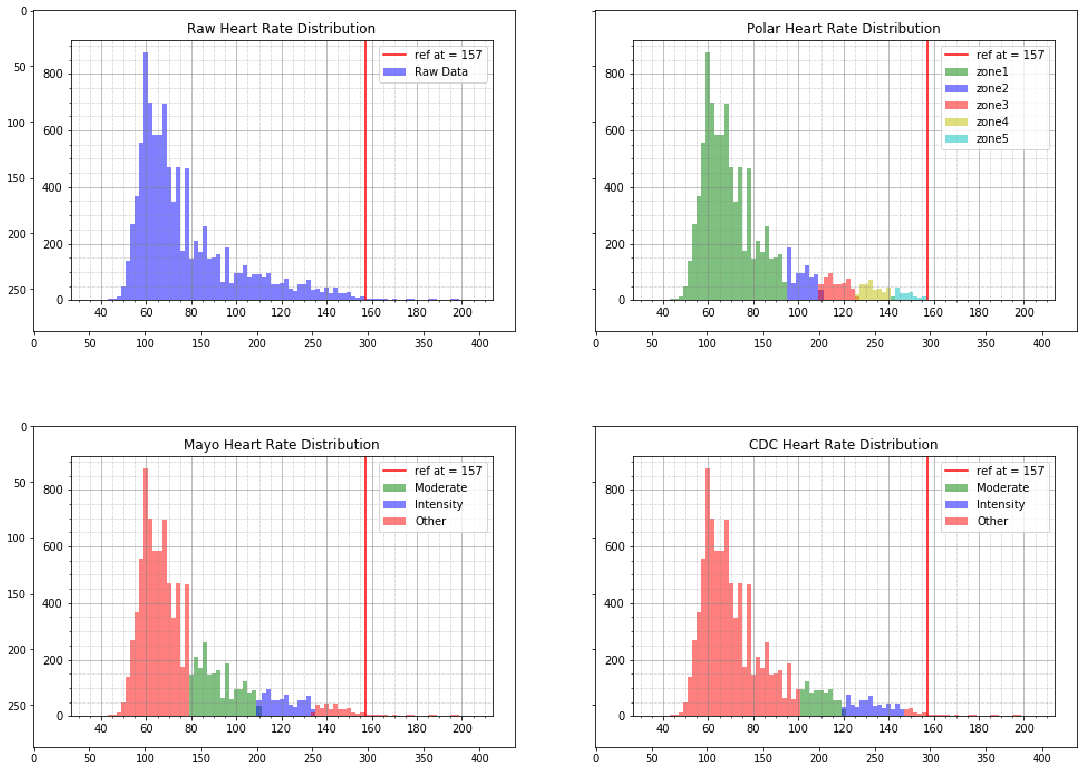

In [21]:
model_histos('data')

# Benchmarking - Histogram Comparison 
The histogram in the upper left is of the raw data with no zones applied. The distribution looks continuous with a tail on the high end. The zones applied are the CDC and Mayo Clinic and Polar recommendations. The CDC and Mayo limits are more conservative than the Polar zones. The Polar zones are more appropriate for atheletes as it is common to achieve the calculated maximum heart rate indicated by the red reference line. 

## Pre-Processing Summary
The dataset has been loaded, columns of interest selected, data filtered and a smaller sample generated to speed execution. Summary statistics and graphical analysis have also been completed. This is a simple 1D dataset with no features or labels.

The most siginificant take-away, highlighted by the distribution,  is that there does not appear to be any clusters. The is no clear separation in any of the data. However, the analysis will continue. The models, particularly a Guassian Mixture Model, may be able to tease apart at least a second distribution. 

Note also that training and test datasets have not been generated. This is becaused it is un-supervised learning. There are no labels for model predictions to be compared against. Instead a 'score', explained more below, will be used to evaluate the model with the best fit. 

# Modeling 
Since the data is not labeled, unsupervised clustering techniques will be utilized. Three models are evaluated: Kmeans, GMM and DBSCAN. The silhouette score will be used as a performance metric to determine the best model. For KMeans and GMM, the hyperparameter of interest is the number of clusters. For DBSCAN the number of clusters is not an input variable. In this case the hyperparametes of interest are the EPS and minimum number of samples. EPS is a measure of cluster distance. 

Kmeans is easy to understand but it is sensitive to outliers. On the other hand, with DBSCAN, not all data points are assigned to a cluster making it more robust to outliers. These points are labeled with a [-1]. And unlike Kmeans and GMM, DBSCAN does not require the number of clusters as a parameter, rather it infers the number of clusters. 

## Kmeans Elbow Plot
The code below calculates and plots the cluster labels and score for a range of k values. 

In [22]:
def scree_KMeans_plot(data,num_clusters):
    ''' This method will calculate Kmeans clusters. The number of clusters will be defined by a range. 
        Kmeans will be used to define the clusters and labels for the data generated. Finally the data 
        will be ploted so the Elbow method can be used to determine the optimum number of clusters. 
    '''
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    plt.figure(figsize=(5,3))
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        #print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        #print ("Cluster Labels: ",np.unique(labels))
        score = (-(kmeans.score(data))/10000000)
        #print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Elbow Method: Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    #print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels

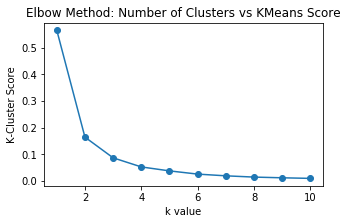

In [23]:
k_values, scores, labels = scree_KMeans_plot(df_sample,11) 

#### Kmeans Score or Inertia
It can be seen that after 5 clusters the rate of improvment for the score diminishes. Consequently 5 is used for the number of clusters. 

## GMM and DBSCAN Models
Two additional models were evaluated. A Guassian Mixture Model (GMM) and DBSCAN. Both are clustering models for unsupervised data. 

### Hyper-Parameter Tuning 
The first step for using these models is to tune the hyper-parameters. Similar to Kmeans, GMM will use the number of clusters, while for DBSCAN, EPS and the minimum number of samples will be used. EPS is a radius that defines the cluster neighborhood. The code and graph for evaluating the DBSCAN hyperparameter is below. 

In [24]:

def hyper(param):
    scores = []
    eps = []

    dbscan_clusters = []
    samples = []
    min_sample = 60
    eps_fixed = 10
    
    if param == 'eps' : 
        myrange = list(range(5,20,2))
        for x in myrange:
            dbscan = DBSCAN(eps=x, min_samples= min_sample)
            labels = dbscan.fit_predict(df_sample.BPM.values.reshape(-1,1))
            dbscan_clusters.append(labels)
            score = silhouette_score(df_sample.BPM.values.reshape(-1,1),dbscan.labels_)
            scores.append(score)
            eps.append(x)
            #print (x,np.unique(dbscan.labels_),round(score,2))
        plt.figure(figsize=(5,3))
        plt.ylim(0.70,0.80)
        plt.ylabel('Silhouette Coefficient')
        plt.xlabel('EPS Hyper-Parameter ')
        plt.title('EPS DBSCAN Hyper-Parameter \n min_samples = ' + str(min_sample))
        plt.grid(True)
        plt.tight_layout(pad=1.0)
        plt.plot(eps,scores,  label = 'eps', marker = 'o')
        plt.savefig('./plots/dbscan_eps.png')
            
    elif param == 'samples' : 
        myrange = list(range(20,100,10))
        for x in myrange:
            dbscan = DBSCAN(eps=eps_fixed, min_samples= x)
            labels = dbscan.fit_predict(df_sample.BPM.values.reshape(-1,1))
            dbscan_clusters.append(labels)
            score_sil = silhouette_score(df_sample.BPM.values.reshape(-1,1),dbscan.labels_)
            scores.append(score_sil)
            samples.append(x)
            #print (x,np.unique(dbscan.labels_),round(score,2))
        plt.figure(figsize=(5,3))
        #plt.ylim(0.7,0.85)
        plt.ylabel('Silhouette Coefficient')
        plt.xlabel('Min_sample Hyper-Parameter ')
        plt.title('Minimum Samples DBSCAN Hyper-Parameter \n eps = ' + str(eps_fixed))
        plt.grid(True)
        plt.tight_layout(pad=1.0)
        plt.plot(samples,scores,  label = 'samples', marker = 'o')
        plt.savefig('./plots/dbscan_samples.png')
        plt.show()
    return scores, eps, dbscan_clusters 

CPU times: user 15.4 s, sys: 4.45 s, total: 19.9 s
Wall time: 20.4 s


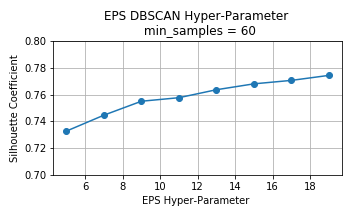

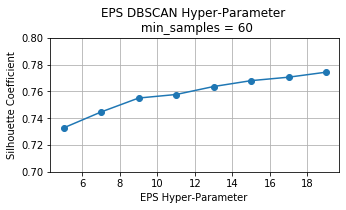

In [25]:
%%time
scores, eps,dbscan_clusters = hyper('eps')
Image('./plots/dbscan_eps.png')

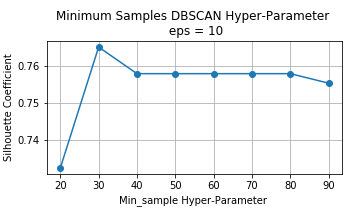

In [26]:
# The silhouette plot for the min_samples plot tends to be unstable. 
# This is becuase more than one cluster needs to be defined for the silhouette score. 
# Consequently, the plot below is displayed from a saved .png file. 

#scores, eps,dbscan_clusters = hyper('samples')
Image('./plots/dbscan_samples.png')

In [27]:
np.unique(dbscan_clusters)

array([-1,  0])

#### DBSCAN Hyper-parameters 
10 was selected as the value for EPS. Minimum samples is 30. With the hyper-parameters now defined, the performance of each model will be evaluated. 

#### Silhouette Score
The silhouette score is a performance metric that all 3 models can be evaluated against. The silhouette score is more robust than the inertia score.  It better comprehends both cohesion, or intra-cluster distances,  as well as the inter-cluster distances, or separation.

The silhouette coefficient can vary from -1 to 1. Values near 1 mean that the instance is well within its cluster and far from other clusters. Higher is better. 

The next few code modules will calculate and plot the silhouette scores for the 3 models. 

In [28]:
%%time
def silhouetteScore(df,num_clusters):
    models = ['kmeans', 'gmm', 'dbscan']
    sil_scores = []
    k_value = []
    model_type = []
    bic_values = []
    dbscan_cluster_labels = []
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
            for mymodel in models:
                    if mymodel == 'kmeans':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            kmeans = KMeans(n_clusters=n_clusters)
                            cluster_label = kmeans.fit_predict(df)
                            score = round(silhouette_score(df,cluster_label),2)
                            sil_scores.append(score)
                            bic_values.append(None)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                            print("Model {} with n_clusters = {}, BIC is {}".format(mymodel,n_clusters, None))

                    elif mymodel == 'gmm': 
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            gmm = mixture.GaussianMixture(n_components=n_clusters,n_init=10)
                            gmm.fit(df)
                            bic_values.append(round(gmm.bic(df),0))
                            cluster_label = gmm.fit_predict(df)
                            score = round(silhouette_score(df,cluster_label),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                            print("Model {} with n_clusters = {}, BIC is {}".format(mymodel,n_clusters, round(gmm.bic(df),0)))

                    elif mymodel == 'dbscan':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            dbscan = DBSCAN(eps=20, min_samples= 100)
                            cluster_label = dbscan.fit_predict(df)
                            dbscan_cluster_labels.append(cluster_label)
                            score = round(silhouette_score(df,cluster_label),2)
                            sil_scores.append(score)
                            bic_values.append(None)
                            print("Model {} with n_clusters = {}, BIC is {}".format(mymodel,n_clusters, None))

    print ("\nFinished!")
    return sil_scores, bic_values,k_value, model_type,dbscan_cluster_labels

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [29]:
%%time
sil_scores,bic_values, k_value, model_type,dbscan_cluster_labels = silhouetteScore(df_sample.BPM.values.reshape(-1,1),11)

Model kmeans with n_clusters = 2, silhouette score is 0.71
Model kmeans with n_clusters = 2, BIC is None
Model gmm with n_clusters = 2, silhouette score is 0.66
Model gmm with n_clusters = 2, BIC is 85860.0
Model dbscan with n_clusters = 2, BIC is None
Model kmeans with n_clusters = 3, silhouette score is 0.64
Model kmeans with n_clusters = 3, BIC is None
Model gmm with n_clusters = 3, silhouette score is 0.61
Model gmm with n_clusters = 3, BIC is 85372.0
Model dbscan with n_clusters = 3, BIC is None
Model kmeans with n_clusters = 4, silhouette score is 0.59
Model kmeans with n_clusters = 4, BIC is None
Model gmm with n_clusters = 4, silhouette score is 0.56
Model gmm with n_clusters = 4, BIC is 85183.0
Model dbscan with n_clusters = 4, BIC is None
Model kmeans with n_clusters = 5, silhouette score is 0.56
Model kmeans with n_clusters = 5, BIC is None
Model gmm with n_clusters = 5, silhouette score is 0.56
Model gmm with n_clusters = 5, BIC is 85113.0
Model dbscan with n_clusters = 5, 

The BaysianGaussianMixture model was also evaluated. There was a warning message that the model
did not converge and consequently is being left out of the analysis. 

In [30]:
np.unique(dbscan_cluster_labels)

array([-1,  0])

In [31]:
df =pd.DataFrame(list(zip(k_value,model_type,sil_scores,bic_values)),columns=['k','model','sil_score','BIC'])
display (df.head(10))

,k,model,sil_score,BIC
0,2,kmeans,0.71,NaN
1,2,gmm,0.66,85860.0
2,2,dbscan,0.77,NaN
3,3,kmeans,0.64,NaN
4,3,gmm,0.61,85372.0
5,3,dbscan,0.77,NaN
6,4,kmeans,0.59,NaN
7,4,gmm,0.56,85183.0
8,4,dbscan,0.77,NaN
9,5,kmeans,0.56,NaN


In [32]:
def bic_plot(df):
    
    # The code below plots the BIC Score 
    
    gmm = df.loc[df.model == 'gmm']
    plt.figure(figsize=(5,3))
    plt.ylabel('BIC Score')
    plt.xlabel('k value')
    plt.title('GMM BIC Score vs Cluster Number')
    plt.grid(True)
    plt.tight_layout(pad=1.0)
    plt.plot(gmm.k,gmm.BIC,  label = 'gmm', marker = 'o')
    plt.xticks(np.arange(1.0, 11, 1.0))
    plt.savefig('./plots/bic_score.png')
    plt.show()

In [33]:
def silhouette_plot(df):
    
    # The code below plots the silhouette score for Kmeans, gmm and dbscan vs k. 
    
    kmeans = df.loc[df.model == 'kmeans']
    gmm = df.loc[df.model == 'gmm']
    dbscan = df.loc[df.model == 'dbscan']
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('k value')
    plt.title('Selecting K for Best Silhouette Score \n Models = KMeans, GMM, DBSCAN')
    plt.ylim=(0.3,1.0)
    plt.grid(True)
    plt.tight_layout(pad=1.0)
    plt.plot(kmeans.k,kmeans.sil_score,  label = 'kmeans', marker = 'o')
    plt.plot(gmm.k,gmm.sil_score,  label = 'gmm', marker = 'o')
    plt.plot(0,dbscan.iat[0,2],  label = 'gmm', marker = 'o')
    plt.xticks(np.arange(1.0, 11, 1.0))
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.legend(['kmeans', 'gmm','dbscan'])
    plt.savefig('./plots/silhouette_scores.png')
    plt.show()

## Modeling Evaluation and Results

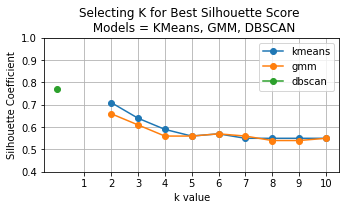

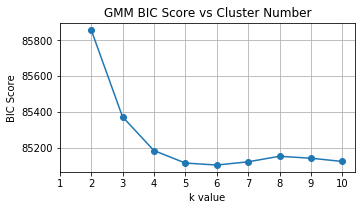

In [34]:
silhouette_plot(df)
bic_plot(df)

### Silhouette Score 
From the graph above, DBSCAN has the highest silhouette score at close to 0.8. 
Since the number of clusters is not a hyperparameter for DBSCAN, only one data point was plotted. GMM and Kmeans had similar performance. 
### BIC Score
The BIC score was calculated for the GMM model since it allows for clusters of different sizes and shapes. It also shows, along with the silhouette score, that after 5 clusters the improvement in scores diminishes. 

### Graphical Analysis
For each of the 3 models, the clusters were mapped on a histogram. The figure below shows the results.

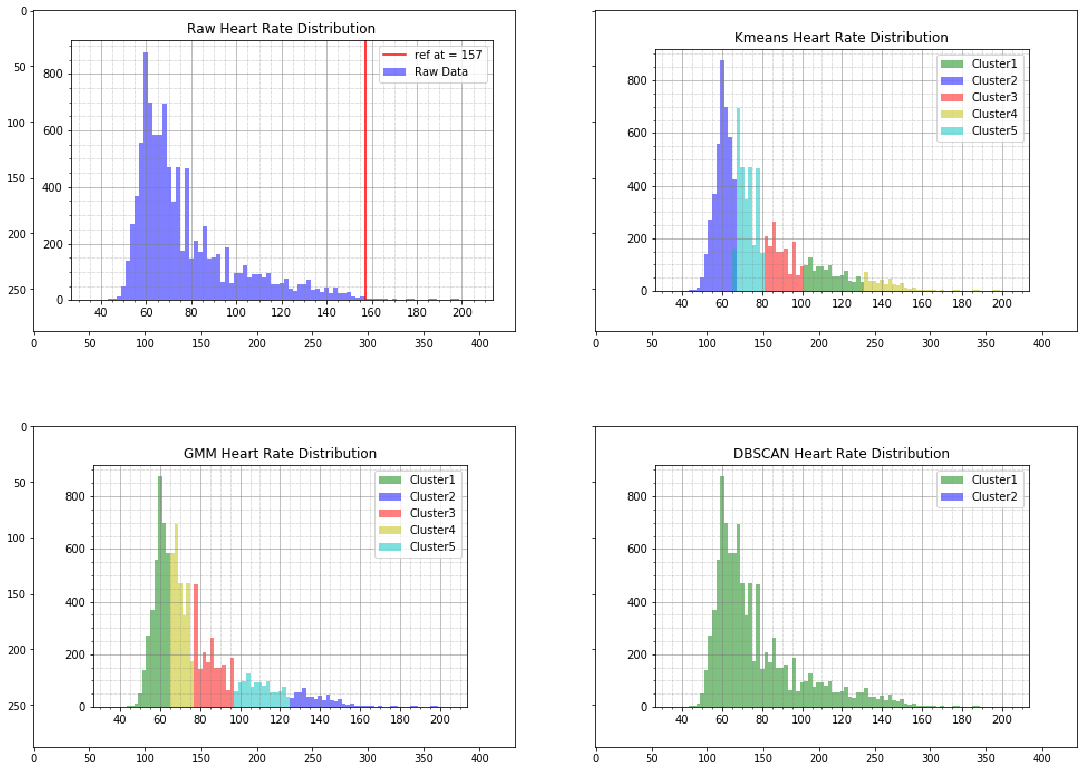

In [35]:
model_histos('model')

The upper left is the raw data with a reference line at the maximum heart rate. The upper right shows the Kmeans result, the lower left is for GMM and the lower right is DBSCAN. Again, the Kmeans and GMM look similar. The module 
below will determine the desciptive statistics for any given cluster. 

In [36]:
display (df2.groupby('Kmeans_Cluster')['BPM'].describe())
display (df2.groupby('GMM_Cluster')['BPM'].describe())
display (df2.groupby('DBSCAN_Cluster')['BPM'].describe())

,count,mean,std,min,25%,50%,75%,max
Kmeans_Cluster,,,,,,,,
0,1071.0,112.882353,8.176967,101.0,106.0,112.0,120.0,129.0
1,3993.0,59.461808,3.947058,36.0,57.0,60.0,63.0,65.0
2,1502.0,88.855526,5.571870,81.0,84.0,87.0,94.0,100.0
3,505.0,145.815842,17.097635,130.0,134.0,141.0,149.0,210.0
4,2929.0,71.862410,4.086311,66.0,68.0,71.0,75.0,80.0


,count,mean,std,min,25%,50%,75%,max
GMM_Cluster,,,,,,,,
0,3567.0,58.823381,3.604491,41.0,57.0,59.0,62.0,64.0
1,631.0,141.713154,18.417947,36.0,131.0,137.0,147.0,210.0
2,1961.0,84.665477,6.000109,77.0,79.0,84.0,90.0,96.0
3,2739.0,69.441402,3.274921,65.0,67.0,69.0,72.0,76.0
4,1102.0,109.290381,7.499990,97.0,103.0,109.0,115.0,124.0


,count,mean,std,min,25%,50%,75%,max
DBSCAN_Cluster,,,,,,,,
-1,24.0,200.125000,6.14543,192.0,195.0,198.0,206.25,210.0
0,9976.0,77.296311,23.04632,36.0,61.0,69.0,86.00,189.0


###  Discussion/Conslusion
DBSCAN achieved the best silhouette coefficient while Kmeans and GMM were comparable. The clusters identified by Kmeans and GMM did not have any separation, suggesting overfitting. However, this may not be the classic definition of over-fitting as any new data would certainly fall into one of the cluster definitions. It can be said that the clusters do not provide any additional insight over  the Polar zones.

With DBSCAN, a [-1] represents an anomaly or noise. Consequently, from the summary statistics above, it can be seen that there is only one cluster identified [0]. However, DBSCAN does an excellent job of identifying these anomalies.  From the table above, the anomalies have a range of 188 to 215 - above the predicted maximum heart rate of 158. These anomalies could be a result of a faulty reading of the heart rate sensor. Providing a method to exclude this data would be of value to algorithms embedded in software or hardware. They could be the result a loose or improperly located wrist band. 

The zones or clusters defined by the CDC and Mayo clinic seem to be insufficient for high intensity training. They both only define 2 zones, moderate and intense. Their upper limits (for a 62-year-old), 133 and 146, respectively, are not close enough to the predicted maximum heart of 158. This heart rate is frequently obtained and to guard so heavily against it may prohibit athletes from achieving their full potential. 

Lastly, the predicted maximum heart rate (220-age) compared extremely well with the data. Although it is not a hard limit. There are what appear to be valid, although few, readings above this limit. For example, take a reading of 166 BPM. It is well below the hardware limit of 210 but only 5% above 158. 
